### Geography of Tweet Sentiment
This notebook does the following:
- Loads the tweet data from files specified below and filters geotagged tweets
- Uses NLTK to get sentiment for each tweet
- Converts the tweet sentiments to a geo dataframe
- Performs a spatial join with PUMA shapefile
- Average sentiment by PUMA
- Visualize the results

In [1]:
tweet_directory = 'tweets/'
pumaFile = '/home/urwa/Documents/Courses/Sem1/PUI/PUIData/Old Data/PUMA/geo_export_f0519f41-2898-4829-af71-3556b078f017.shp'

In [2]:
from __future__ import print_function
import os
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import requests 
import json
import numpy as np
import io
import json
import nltk
import shapely
from geopandas.tools import sjoin
from fiona.crs import from_epsg
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

%matplotlib inline

In [3]:
def getSentimentTweet(t):
    sentences = nltk.tokenize.sent_tokenize(t)
    s = []
    for sentence in sentences:
        s.append(sid.polarity_scores(sentence)["compound"])
    return (np.mean(s))

In [4]:
def loadGeoTaggedTwitterData():
    with open(tweetFiles[0]) as json_file:  
        data = json.load(json_file)
    for i in range(1, len(tweetFiles)):
        with open(tweetFiles[i]) as json_file:  
            data += json.load(json_file)
    print("Tweets: ",len(data))
    tweets = [(d['text'],d['geo']['coordinates']) for i,d in enumerate(data) if d['geo'] is not None]
    print('Geotagged: ',len(tweets))
    return tweets

In [5]:
def getSentimentGeoDf(tweets):
    sentiment = [getSentimentTweet(t[0]) for t in tweets]
    lat = [t[1][0] for t in tweets]
    lon = [t[1][1] for t in tweets]
    
    df = pd.DataFrame({'lat':lat,'lon':lon,'sentiment':sentiment})
    df['lonlat'] = list(zip(df["lon"].values,df["lat"].values))
    df['geometry'] = df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
    gdf = gpd.GeoDataFrame(df)
    return gdf

In [6]:
pumashp = gpd.GeoDataFrame.from_file(pumaFile)
print(pumashp.shape)
pumashp.head(3)

(55, 4)


,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...


In [7]:
tweetFiles = os.listdir(tweet_directory)
tweetFiles = [tweet_directory+t for t in tweetFiles]
tweets = loadGeoTaggedTwitterData()

Tweets:  64776
Geotagged:  9942


In [8]:
tweetGdf = getSentimentGeoDf(tweets)
print(tweetGdf.shape)
tweetGdf.head(3)

(9942, 5)


,lat,lon,sentiment,lonlat,geometry
0,40.898333,-74.029827,0.0,"(-74.02982712, 40.89833309)",POINT (-74.02982711999999 40.89833309)
1,40.847698,-73.169601,0.0,"(-73.169601, 40.847698)",POINT (-73.169601 40.847698)
2,40.847698,-73.169601,0.0,"(-73.169601, 40.847698)",POINT (-73.169601 40.847698)


In [9]:
tweetGdf.dropna(subset=["lat", "lon"]).shape

(9942, 5)

In [10]:
resultGdf = gpd.sjoin(pumashp,tweetGdf,how='inner')
resultGdf.shape

(6857, 9)

In [11]:
pumaSent = resultGdf[['puma','sentiment']].groupby('puma').mean()
print(pumaSent.shape)
pumasSentGdf = pumashp.merge(pumaSent, on='puma', how='left')

(55, 1)


/home/urwa/miniconda3/envs/usa/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


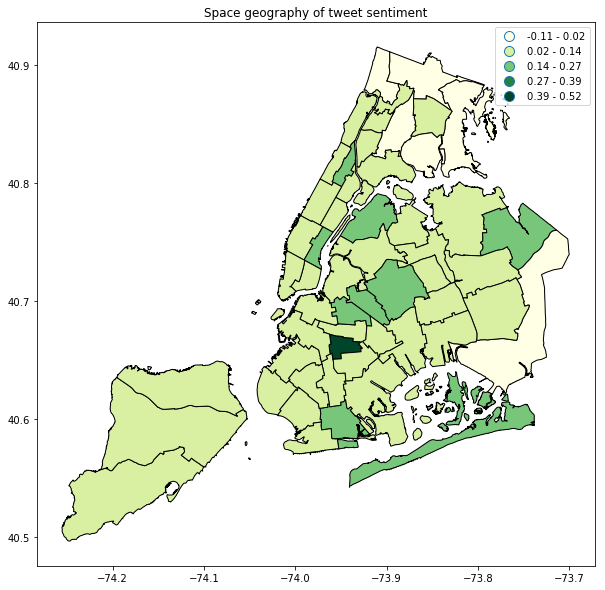

In [12]:
intervals = 10

fig, ax = plt.subplots(figsize=(10, 10))
pumasSentGdf.plot(color="black",ax=ax)
pumasSentGdf.dropna().plot(column="sentiment", scheme='Equal_Interval', cmap="YlGn",\
                  edgecolor='black',legend=True,ax=ax)
ax.set_title('Space geography of tweet sentiment')

In [13]:
pumaSent = pumaSent.reset_index()
pumaSent.to_csv('pumaSentTweet.csv',index=False)